tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


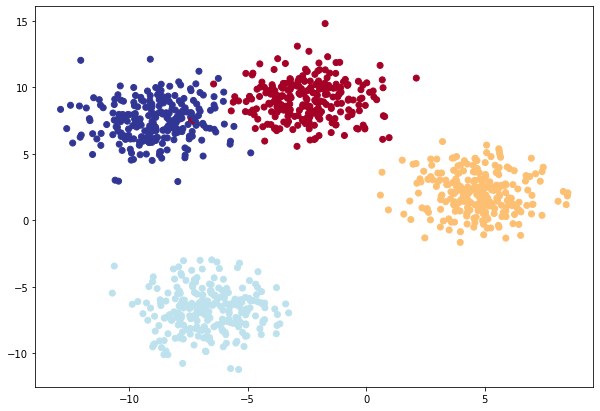

In [45]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch.nn as nn

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
value_blob_train, value_blob_test, expect_blob_train, expect_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [47]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = 2, out_features = 16),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features = 16, out_features = 16),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features = 16, out_features = 4)
        )
  def forward(self, x):
    return self.linear_layer_stack(x)
model = CircleModel().to(device)
model

CircleModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.1)

In [49]:
def accuracy(expected, predicted):
  corrects = torch.eq(expected, predicted).sum().item()
  acc = (corrects/len(expected))*100
  return acc

In [50]:
torch.manual_seed(42)

epochs = 100

# Put data to target device
X_blob_train, y_blob_train = value_blob_train.to(device), expect_blob_train.to(device)
X_blob_test, y_blob_test = value_blob_test.to(device), expect_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model.train()

    y_logits = model(X_blob_train)
    #softmax shows hte probability of something being certain class
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy(y_blob_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy(y_blob_test, test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.91835, Acc: 24.50% | Test Loss: 0.36935, Test Acc: 94.00%
Epoch: 10 | Loss: 0.10736, Acc: 99.25% | Test Loss: 0.09624, Test Acc: 99.50%
Epoch: 20 | Loss: 0.06734, Acc: 99.25% | Test Loss: 0.05931, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05217, Acc: 99.12% | Test Loss: 0.04436, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04433, Acc: 99.12% | Test Loss: 0.03639, Test Acc: 99.50%
Epoch: 50 | Loss: 0.03960, Acc: 99.12% | Test Loss: 0.03148, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03647, Acc: 99.12% | Test Loss: 0.02816, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03426, Acc: 99.12% | Test Loss: 0.02577, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03263, Acc: 99.12% | Test Loss: 0.02397, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03138, Acc: 99.12% | Test Loss: 0.02256, Test Acc: 99.50%


In [55]:
#download help
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

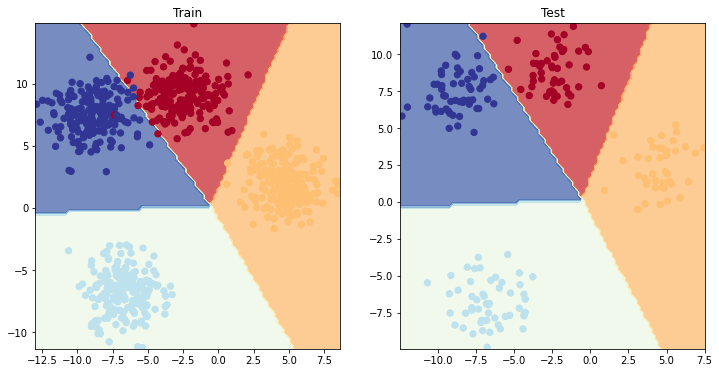

In [58]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)